# Remap OSI SAF SIC CDR to LAT-LON grid

This notebook demonstrate accessing monthly SIC CDR data from EUMETSAT OSI SAF reproject them to a simple global lat/lon grid. The remapping is based on Pytroll's pyresample. After remapping, a netCDF file is written.

We implement the mapping in several steps to try and fill as many target grid cells as possible, yet not smearing the input field too much. The exact parameters for the remapping step will have to be adapted for the various target grids.

This notebook is part of the preparation to submit the OSI SAF SIC CDR to Obs4MIPS, in support to CMIP7.

In [111]:
import os
import xarray as xr
import numpy as np
from datetime import date, datetime, timedelta, time
from dateutil import rrule, relativedelta
import uuid
from copy import copy

import pyresample as pr

import json

from matplotlib import pylab as plt
from matplotlib import cm
from cartopy import crs as ccrs, feature as cfeature

## Configuration

The next cell is a 'parameters' cell, to allow runs with papermill, e.g.

`> papermill -r dt 20031203 -r area sh Remap\ OSI\ SAF\ and\ CCI\ SIC\ CDRs.ipynb Remap\ OSI\ SAF\ and\ CCI\ SIC\ CDRs_out.ipynb`

`> papermill -r dt 20031203 -r area sh -r outdir /lustre/storeB/users/thomasl/THREDDS/SICs_4HCLIM/ Remap\ OSI\ SAF\ and\ CCI\ SIC\ CDRs.ipynb - > /dev/null`

`loop_wrapper --cpu 5 20031201 20031231 'papermill -r dt {d:} -r area sh -r outdir /lustre/storeB/users/thomasl/THREDDS/SICs_4HCLIM Remap\ OSI\ SAF\ and\ CCI\ SIC\ CDRs.ipynb - > /dev/null'`

In [112]:
# date to be remapped
dt = date(2010,12,1)
outdir = '.'
resol = 0.5

In [113]:
# handle datestring format and conversion
if not isinstance(dt, date):
    if isinstance(dt,str):
        if len(dt) == 6:
            dt += '16'
        if len(dt) != 8:
            raise ValueError("Datestring should br YYYYMM or YYYYMMDD")
        try:
            yyyy,mm,dd = int(dt[:4]),int(dt[4:6]),int(dt[6:8])
            dt = date(yyyy,mm,dd)
        except Exception:
            raise ValueError('Invalid datestring {}'.format(dt))
    
# check outdir exists
if not os.path.exists(outdir):
    raise ValueError('Output directory does not exist ({})'.format(outdir))

In [114]:
# prioritization for input data source
src_prioritized_list = ['osisaf-v3',]

## Define the target grid and land mask

/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 4 neighbours within 500.0 m for some data points
  get_neighbour_info(source_geo_def,


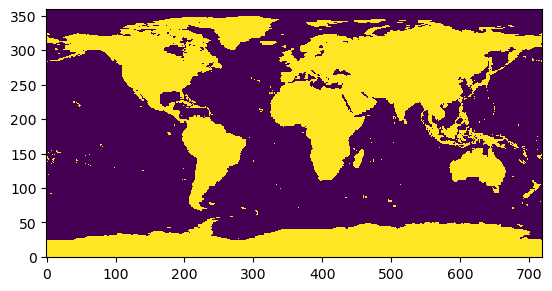

(720, 2)
(360, 2)


In [115]:
# LAND/OCEAN MASK
#  we use an era5 lat/lon land mask
lmask_file = '/home/thomasl/Downloads/era5_20240101.nc'

lmask_latn = 'latitude'
lmask_lonn = 'longitude'
lmask_lsmn = 'lm'

lmask_ds = xr.open_dataset(lmask_file)
lmask_lon_1d = lmask_ds[lmask_lonn][:].to_numpy()
lmask_lon_1d = pr.utils.wrap_longitudes(lmask_lon_1d)
lmask_lat_1d = lmask_ds[lmask_latn][:].to_numpy()
lmask_lon, lmask_lat = np.meshgrid(lmask_lon_1d, lmask_lat_1d)

lmask_geom = pr.SwathDefinition(lmask_lon, lmask_lat)
lmask_lsm = lmask_ds[lmask_lsmn][0,:].to_numpy().astype('bool')

# TARGET grid
trg_lon_1d = np.arange(-180.+resol*0.5, +180. , resol)
trg_lat_1d = np.arange(-90.+resol*0.5, +90. , resol)
trg_lon, trg_lat = np.meshgrid(trg_lon_1d, trg_lat_1d)

trg_geom = pr.SwathDefinition(trg_lon, trg_lat)
trg_lmask = pr.kd_tree.resample_gauss(lmask_geom, lmask_lsm, trg_geom,
                                    radius_of_influence=resol*1000, sigmas=resol*1000, neighbours=4,fill_value=np.nan)

lmask_t = 0.9
trg_lmask = np.where(trg_lmask<lmask_t,0,1).astype('int')
plt.imshow(trg_lmask, vmin=0, vmax=1, interpolation='none', origin='lower')
plt.show()

trg_lon_1d_bnds = np.column_stack((trg_lon_1d - 0.5*resol, trg_lon_1d + 0.5*resol))
trg_lat_1d_bnds = np.column_stack((trg_lat_1d - 0.5*resol, trg_lat_1d + 0.5*resol))

print(trg_lon_1d_bnds.shape)
print(trg_lat_1d_bnds.shape)

## Locate the OSI SAF CDR file to use as source

In [116]:
# A routine to reconstruct the unfiltered, unthresholded SICs from a OSI SAF SIC CDR file
def reconstruct_sic(ds):
    ice_conc = ds['ice_conc'].to_masked_array()
    raw_ice_conc_values = ds['raw_ice_conc_values'].to_masked_array()
    status_flag = ds['status_flag'].to_masked_array().astype('short')
    
    # combine ice_conc with raw_ice_conc_values using the status_flag
    new_ice_conc = copy(ice_conc)
    raw_100_mask = np.array((ice_conc==100) * (~raw_ice_conc_values.mask))
    new_ice_conc[raw_100_mask] = raw_ice_conc_values[raw_100_mask]
    
    new_ice_conc[(status_flag & 4) == 4] = raw_ice_conc_values[(status_flag & 4) == 4]

    # re-enter "full" ice_conc into the xarray dataset
    ds['ice_conc'][:] = new_ice_conc
    return ds

def get_sic_filename(dt, area, cdr='osisaf-v3-cdr', monthly=False):

    dt_str = '{:%Y%m%d}1200'.format(dt)
    if monthly:
        dt_str = '{:%Y%m}'.format(dt)
    
    if cdr == 'osisaf-v3-cdr':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v3p0_{d:}.nc'.format(a=area, d=dt_str)
    elif cdr == 'osisaf-v3-cdr-patch':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v3p0-patch_{d:}.nc'.format(a=area, d=dt_str)
    elif cdr == 'osisaf-v3-icdr':
        fn = 'ice_conc_{a:}_ease2-250_icdr-v3p0_{d:}.nc'.format(a=area, d=dt_str)
    elif cdr == 'osisaf-v3-icdrft':
        fn = 'ice_conc_{a:}_ease2-250_icdrft-v3p0_{d:}.nc'.format(a=area, d=dt_str)
    elif cdr == 'osisaf-v2':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v2p0_{d:}.nc'.format(a=area, d=dt_str)
    elif cdr == 'osisaf-v3-amsr':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v3p0-amsr_{d:}.nc'.format(a=area, d=dt_str)
    elif cdr == 'sicci-hr-sic':
        fn = 'ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-{a:}-{d:%Y%m%d}-fv3.0.nc'.format(a=area.upper(), d=dt)
    else:
        raise ValueError("Do not know about CDR '{}'".format(cdr))
    
    return fn

def get_sic_url(dt, area, cdr='osisaf-v3-cdr', monthly=False):
    
    fn = get_sic_filename(dt, area, cdr=cdr, monthly=monthly)
    
    if cdr == 'osisaf-v3-cdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files'
    elif cdr == 'osisaf-v3-cdr-patch':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450apatch_files'
    elif cdr == 'osisaf-v3-icdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files'
    elif cdr == 'osisaf-v3-icdrft':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files'
    elif cdr == 'osisaf-v2-cdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_v2p0_files'
    elif cdr == 'osisaf-v3-amsr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_amsr_458_files'
    elif cdr == 'sicci-hr-sic':
        url = 'https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/{:}'.format(area.upper())
    else:
        raise ValueError("Do not know about CDR '{}'".format(cdr))
        
    if cdr == 'osisaf-v3-cdr-patch':
        url = os.path.join(url, fn)
    elif monthly:
        url = os.path.join(url, 'monthly', '{:%Y/}'.format(dt), fn)
    else:
        url = os.path.join(url,'{:%Y/%m/}'.format(dt), fn)
    
    return url

def find_sic_file(dt, area, src_prioritized_list=('sicci-hr-sic', 'osisaf-v3',), verbose = False, monthly = False):
    
    # possibly extend the list of prioritized sources (e.g. 'osisaf-v3' calls for the ICDRs and the CDR)
    ext_src_prioritized_list = []
    for src in src_prioritized_list:
        if src == 'osisaf-v3':
            # this is calling for both the ICDRs and the CDR
            ext_src_prioritized_list.append('osisaf-v3-icdrft')
            ext_src_prioritized_list.append('osisaf-v3-icdr')
            ext_src_prioritized_list.append('osisaf-v3-cdr-patch')
            ext_src_prioritized_list.append('osisaf-v3-cdr')
        else:
            ext_src_prioritized_list.append(src)
    
    # find the path/url to the file. There are precedence rules for what type of files
    #   to select.
    fn = None
    found_one_file = False
    for src in ext_src_prioritized_list:
        fn = get_sic_url(dt, area, cdr=src, monthly=monthly)
        if verbose:
            print("Test ", src, fn)
        try:
            # this url exists, append it and move to next date
            ds = xr.open_dataset(fn)
            found_one_file = True
            break
        except OSError:
            # no valid file at this url, check the next source in the prioritized list
            pass
        
    # no file found. Add a warning (but we can continue)
    if not found_one_file:
        fn = None
        src = None
        if verbose:
            print("WARNING: could not find SIC CDR file for {} {}".format(area, dt))
            
            
    return fn, src

print(get_sic_url(dt, 'nh'))
print(get_sic_url(dt, 'sh', cdr='sicci-hr-sic'))
print(find_sic_file(dt, 'sh', src_prioritized_list=src_prioritized_list))
print(find_sic_file(date(2023,3,31), 'nh', src_prioritized_list=src_prioritized_list, verbose=True))
print(find_sic_file(date(2023,3,31), 'sh', src_prioritized_list=src_prioritized_list, verbose=True,monthly=True))
    

https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/2010/12/ice_conc_nh_ease2-250_cdr-v3p0_201012011200.nc
https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/SH/2010/12/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-SH-20101201-fv3.0.nc
('https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/2010/12/ice_conc_sh_ease2-250_cdr-v3p0_201012011200.nc', 'osisaf-v3-cdr')
Test  osisaf-v3-icdrft https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdrft-v3p0_202303311200.nc
Test  osisaf-v3-icdr https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303311200.nc
('https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303311200.nc', 'osisaf-v3-icdr')
Test  osisaf-v3-icdrft https://thr

## Read the SIC and prepare the remapping

Source file (osisaf-v3-cdr): https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/2010/ice_conc_nh_ease2-250_cdr-v3p0_201012.nc
Source file (osisaf-v3-cdr): https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/2010/ice_conc_sh_ease2-250_cdr-v3p0_201012.nc


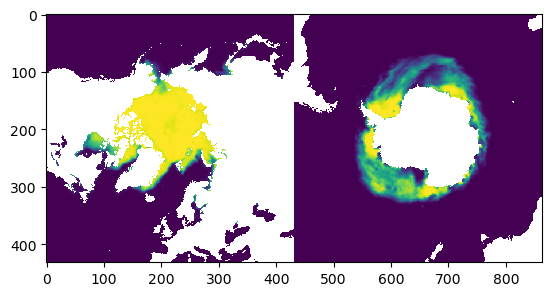

In [117]:
src_lats = []
src_lons = []
src_dats = []
src_flgs = []
src_files = []
for area in ('nh', 'sh'):
    src_file, src_id = find_sic_file(dt, area, src_prioritized_list=src_prioritized_list, monthly=True)
    print("Source file ({}): {}".format(src_id, src_file))
    src_ds = xr.open_dataset(src_file)
    src_ds = reconstruct_sic(src_ds)

    src_lat = src_ds['lat'][:].to_numpy()
    src_lon = src_ds['lon'][:].to_numpy()

    # Prepare the source geometry for pyresample. It works best by removing masked values at runing to 1D
    src_dat = src_ds['ice_conc'][0,:].to_masked_array()
    src_flg = src_ds['status_flag'][0,:].to_numpy().astype('int16')

    # store
    src_lats.append(src_lat)
    src_lons.append(src_lon)
    src_dats.append(src_dat)
    src_flgs.append(src_flg)
    src_files.append(src_file)

# 'concatenate' the NH and SH maps into one dataset
src_lat = np.column_stack(src_lats)
src_lon = np.column_stack(src_lons)
src_dat = np.column_stack(src_dats)
src_flg = np.column_stack(src_flgs)

plt.imshow(src_dat, interpolation='none', vmin=0, vmax=100)
plt.show()

# remove climatological zeros (we will put them back after resampling)
src_dat[src_flg==128] = np.ma.masked

src_lon_dat = src_lon[~src_dat.mask]
src_lat_dat = src_lat[~src_dat.mask]
src_geom_dat = pr.SwathDefinition(src_lon_dat, src_lat_dat)

# Prepare the data in the same 1D shape as the src lat/lon
src_dat_1d = src_dat.compressed()

# Prepare the resampling of the flag
src_lon_flg = src_lon.flatten()
src_lat_flg = src_lat.flatten()
src_geom_flg = pr.SwathDefinition(src_lon_flg, src_lat_flg)
src_flg_1d  = src_flg.flatten()

## Perform the resampling from source to target geometry

In [118]:
# prepare the parameters to the first resampling
roi = 50000
sigma = 12500
nbgh = 8
if 'siccip-v3' in src_id:
    roi /= 3
    sigma /= 3

In [119]:
# Do a first remapping:
#  we remap the SICs and specify an un-physical value for the fill_value, which will appear where
#  target grid cells have no close-enough source values for the resampling. We will have to deal
#  with these cells separately.
fill_value = None
trg_dat = pr.kd_tree.resample_gauss(src_geom_dat, src_dat_1d, trg_geom,
                                    radius_of_influence=roi, sigmas=sigma, neighbours=nbgh,
                                    fill_value=fill_value)

trg_flg = pr.kd_tree.resample_nearest(src_geom_flg, src_flg_1d, trg_geom,
                                    radius_of_influence=roi)

trg_dat = np.ma.array(trg_dat)

# apply the target land-sea mask
trg_dat[trg_lmask] = np.ma.masked
trg_flg[trg_lmask] = 1

# apply the resampled max extent climatology
trg_dat[trg_flg == 128] = 0

# enforce climatology for cells of latitudes lower than 50
enforce_clim = (abs(trg_lat)<50)*(trg_lmask==0)
trg_dat[enforce_clim] = 0
trg_flg[enforce_clim] = 128

/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 8 neighbours within 50000 m for some data points
  get_neighbour_info(source_geo_def,


In [120]:
# prepare the parameters to the second resampling
roi = 75000
sigma = 25000
nbgh = 12

# Do a second remapping:
#   remap the remaining "fill_value" cells that are not over the target land (as given by trg_lsm)

gapfill_iter = 0
nb_fill_value = (trg_dat==fill_value).sum()
while nb_fill_value > 0 and gapfill_iter < 10:
    print("Iter {}: Attempt to fill {} gaps.".format(gapfill_iter+1, nb_fill_value))
    # define the gaps
    trg_gaps = (trg_dat==fill_value)
    trg_gaps_lat = trg_lat[trg_gaps]
    trg_gaps_lon = trg_lon[trg_gaps]
    trg_gaps_geom = pr.SwathDefinition(trg_gaps_lon, trg_gaps_lat)

    # define the nogaps
    trg_nogaps = (trg_dat!=fill_value).filled(False)
    trg_nogaps_lat = trg_lat[trg_nogaps]
    trg_nogaps_lon = trg_lon[trg_nogaps]
    trg_nogaps_geom = pr.SwathDefinition(trg_nogaps_lon, trg_nogaps_lat)
    trg_nogaps_data = trg_dat[trg_nogaps].compressed()
 
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,3,1)
    ax.imshow(np.ma.array(trg_gaps,mask=~trg_gaps), cmap=cm.coolwarm, vmin=-1, vmax=+1, interpolation='none')
    ax.imshow(-1*np.ma.array(trg_nogaps,mask=~trg_nogaps), cmap=cm.coolwarm, vmin=-1, vmax=+1, interpolation='none')
    ax.imshow(0*np.ma.array(trg_lsm,mask=~trg_lsm), cmap=cm.coolwarm, vmin=-1, vmax=+1, interpolation='none')
    ax.set_title('GAPS (red) and NOGAPS (blue)')
    ax = fig.add_subplot(1,3,2)
    ax.imshow(trg_dat, interpolation='none', vmin=0, vmax=fill_value, cmap=cm.winter)
    ax.set_title('BEFORE GAP FILLING')

    
    # do the remapping of no gaps to gaps
    trg_gaps_dat = pr.kd_tree.resample_gauss(trg_nogaps_geom, trg_nogaps_data, trg_gaps_geom,
                                        radius_of_influence=roi, sigmas=sigma, neighbours=nbgh,
                                        fill_value=fill_value)
    
    # reassign the interpolated gaps in the original array, record the interpolation with
    #   a status flag value
    trg_dat[trg_gaps] = trg_gaps_dat
    trg_flg[trg_gaps] = 32

    ax = fig.add_subplot(1,3,3)
    ax.imshow(trg_dat, interpolation='none', vmin=0, vmax=fill_value, cmap=cm.winter)
    ax.set_title('AFTER GAP FILLING')
    plt.show()
    
    # update the counter of missing data
    nb_fill_value = (trg_dat==fill_value).sum()
    gapfill_iter += 1
    
print("After {} remappings, there are {} gaps left.".format(gapfill_iter, nb_fill_value))

# These gaps we could not fill, turn them back to masked value, and record in the status_flag
trg_gaps = (trg_dat==fill_value)
trg_flg[trg_gaps] = 256
trg_dat[trg_gaps] = np.ma.masked

After 0 remappings, there are 0 gaps left.


In [121]:
# apply the resampled open water mask and threshold at > 100 and < 0
trg_dat[(trg_flg & 4)==4] = 0
trg_dat[trg_dat>100] = 100
trg_dat[trg_dat<0] = 0

## Some plots to check things look good in the target geometry

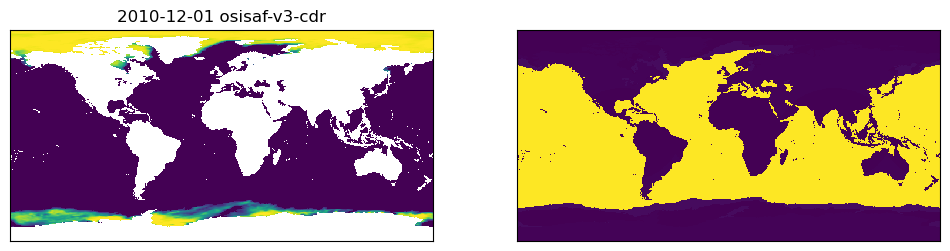

In [122]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.imshow(trg_dat, interpolation='none',vmin=0, vmax=100, origin='lower')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('{} {}'.format(dt, src_id))
ax = fig.add_subplot(1,2,2)
ax.imshow(trg_flg, interpolation='none', origin='lower')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Prepare a netCDF file with the resampled field

We first prepare an xarray dataset, then write it to netCDF. We start from the template of the "ice_conc" variable in the source file and transfer variables and dimensions from the target file.

In [123]:
trg_ds = xr.open_dataset(lmask_file, mask_and_scale=False, decode_times=False).isel(time=0)
src_ds = xr.open_dataset(src_file, mask_and_scale=False, decode_times=False)

print("TARGET: ", trg_ds)
print()

print("SOURCE: ", src_ds)
print()

print(src_ds.attrs)

TARGET:  <xarray.Dataset> Size: 44MB
Dimensions:    (longitude: 1440, latitude: 721)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
    time       int32 4B 1086960
Data variables: (12/18)
    u10        (latitude, longitude) int16 2MB ...
    v10        (latitude, longitude) int16 2MB ...
    t2m        (latitude, longitude) int16 2MB ...
    cvh        (latitude, longitude) int16 2MB ...
    istl1      (latitude, longitude) int16 2MB ...
    cl         (latitude, longitude) int16 2MB ...
    ...         ...
    skt        (latitude, longitude) int16 2MB ...
    sd         (latitude, longitude) int16 2MB ...
    slt        (latitude, longitude) int16 2MB ...
    tcsw       (latitude, longitude) int16 2MB ...
    swvl1      (latitude, longitude) int16 2MB ...
    lm         (latitude, longitude) float64 8MB ...
Attributes:
    Conventions:  CF-1.6
    history:      F

In [124]:
# Prepare coordinates:
out_coords = {'time': src_ds['time'],
              'lat': trg_lat_1d,
              'lon': trg_lon_1d}

# Prepare the (global) attributes
out_attrs = src_ds.attrs

# Prepare the data variables
out_dims = out_coords.keys()
out_dat={'ice_conc':( out_dims, trg_dat[None,:,:], \
                     {a: src_ds['ice_conc'].attrs[a] for a in ('standard_name', 'long_name', 'comment', 'units', )}),
         'status_flag': ( out_dims, trg_flg[None,:,:], \
                     {a: src_ds['status_flag'].attrs[a] for a in ('standard_name', 'long_name', 'comment', 'valid_min', 'valid_max', \
                                                               'flag_masks', 'flag_meanings', 'flag_descriptions')}),
         'time_bnds':( src_ds['time_bnds'].dims, src_ds['time_bnds'].to_numpy(), None),
         'lat_bnds':( ('lat', 'nv'), trg_lat_1d_bnds, None),
         'lon_bnds':( ('lon', 'nv'), trg_lon_1d_bnds, None)
        }

# Create the output xarray dataset from the above elements
out_ds = xr.Dataset(out_dat, out_coords, out_attrs)

# Work on the encoding of the fields for writing to netCDF4

out_ds.lat.attrs = {
    "bounds": "lat_bnds",
    "units": "degrees_north",
    "axis": "Y",
    "long_name": "Latitude",
    "standard_name": "latitude"
}

out_ds.lon.attrs = {
    "bounds": "lon_bnds",
    "units": "degrees_east",
    "axis": "X",
    "long_name": "Longitude",
    "standard_name": "longitude"
}

# global attributes
out_ds.attrs['title'] = "Regridded " + out_ds.attrs['title']

# below would be better handled if we had accessed to an AreaDefinition object
out_ds.attrs['geospatial_lat_min'] = -90.
out_ds.attrs['geospatial_lat_max'] = +90.
out_ds.attrs['geospatial_lon_min'] = -180.
out_ds.attrs['geospatial_lon_max'] = +180.
out_ds.attrs['spatial_resolution'] = '{} degrees'.format(resol)
del out_ds.attrs['geospatial_bounds_crs']

now = datetime.utcnow().replace(microsecond=0)
out_ds.attrs['history'] = now.isoformat()+'Z' + ' regridding to LAT/LON' + '\n' + out_ds.attrs['history']
out_ds.attrs['date_created'] = now.date().isoformat()
out_ds.attrs['tracking_id'] = str(uuid.uuid4())
for a in ('doi', 'id', 'naming_authority'):
    try:
        del out_ds.attrs[a]
    except:
        pass

# encoding
encoding = {'ice_conc': {'_FillValue': -999.},
            'status_flag': {'dtype':src_ds['status_flag'].dtype, '_FillValue':-1},
            'time': {'_FillValue':None}, 'time_bnds': {'_FillValue':None},
            'lat': {'_FillValue':None}, 'lon': {'_FillValue':None},
            'lat_bnds': {'_FillValue':None}, 'lon_bnds': {'_FillValue':None},}

for v in encoding.keys():
    encoding[v]['zlib']=True

print(out_ds)

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 1, lat: 360, lon: 720, nv: 2)
Coordinates:
  * time         (time) float64 8B 1.04e+09
  * lat          (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon          (lon) float64 6kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Dimensions without coordinates: nv
Data variables:
    ice_conc     (time, lat, lon) float64 2MB nan nan nan ... 98.52 98.52 98.52
    status_flag  (time, lat, lon) int16 518kB 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0
    time_bnds    (time, nv) float64 16B 1.039e+09 1.041e+09
    lat_bnds     (lat, nv) float64 6kB -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
    lon_bnds     (lon, nv) float64 12kB -180.0 -179.5 -179.5 ... 179.5 180.0
Attributes: (12/40)
    title:                     Regridded Monthly Sea Ice Concentration Climat...
    summary:                   This climate data record of sea ice concentrat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    geospatial_lat_min:      

In [125]:
# Write to netCDF file

out_n = os.path.basename(src_files[0])
out_n = out_n.replace('_nh_ease2-250_', '_glb_latlon-{:03d}deg_'.format(int(resol*100)))
out_n = os.path.join(outdir, out_n)

if os.path.exists(out_n):
    os.remove(out_n)

out_ds.to_netcdf(out_n, encoding=encoding, format='NETCDF4_CLASSIC', unlimited_dims='time')
print(out_n + " is ready.")

./ice_conc_glb_latlon-050deg_cdr-v3p0_201012.nc is ready.
